In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, os

sys.path.insert(0, ".")
os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import matplotlib.pyplot as plt

from pixel_art.analysis.gather_evaluation import get_domains, compute_all_results
from pixel_art.analysis.plot_errors import (
    plot_all_errors,
    plot_error_vs_sparsity,
    plot_errors_for_domain,
)

In [4]:
all_results = compute_all_results(10)

domains:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def print_incompletes(all_results):
    for dom, for_dom in all_results.items():
        for setting, for_setting in for_dom.items():
            for k3, x in for_setting.items():
                if x.shape[0] == 9:
                    continue
                print(dom, setting, k3, x.shape[0])


print_incompletes(all_results)

In [6]:
def only_mt(res):
    return {
        dom: {
            setting: {"MT": for_setting["MT"]}
            for setting, for_setting in for_dom.items()
        }
        for dom, for_dom in res.items()
    }

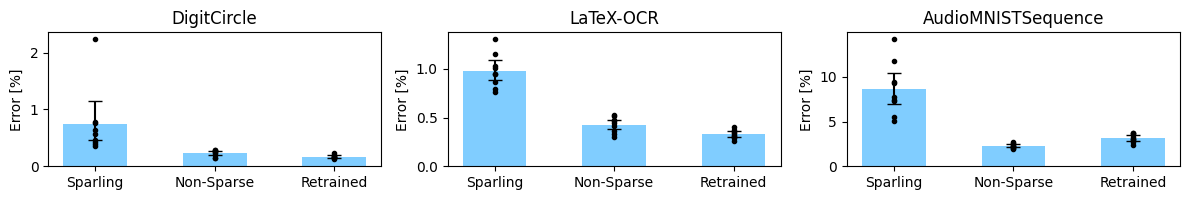

In [7]:
plot_all_errors(
    get_domains(only_mt=True), only_mt(all_results), columns=["e2e_edit"], height=2.1
)
plt.savefig("output/all_e2e_error.png")
plt.show()

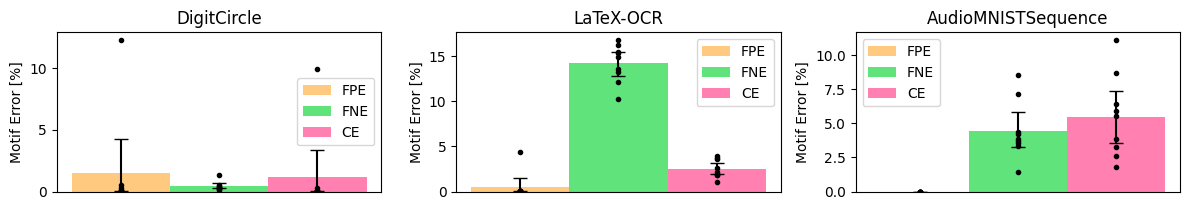

In [8]:
plot_all_errors(
    get_domains(only_mt=True),
    only_mt(all_results),
    columns=["fpe", "fne", "ce"],
    height=2.2,
    ylabel="Motif Error [%]"
)
plt.savefig("output/all_motif_error.png")
plt.show()

In [9]:
mean_results = {
    dom: {k: v.mean() for k, v in all_results[dom][0].items()} for dom in all_results
}
mean_results

{'DigitCircle': {'ST': fne          0.982595
  fpe          0.002476
  ce          22.189985
  e2e_edit     2.106582
  dtype: float64,
  'MT': fne         0.422309
  fpe         1.479519
  ce          1.156094
  e2e_edit    0.737315
  dtype: float64},
 'LaTeX-OCR': {'MT': ce           2.499530
  fpe          0.529159
  fne         14.199312
  e2e_edit     0.979646
  dtype: float64},
 'AudioMNISTSequence': {'MT': ce          5.471335
  fpe         0.000000
  fne         4.464284
  e2e_edit    8.651672
  dtype: float64}}

In [10]:
mean_results["AudioMNISTSequence"]["MT"][["ce", "fpe", "fne"]].sum()

9.93561922262146

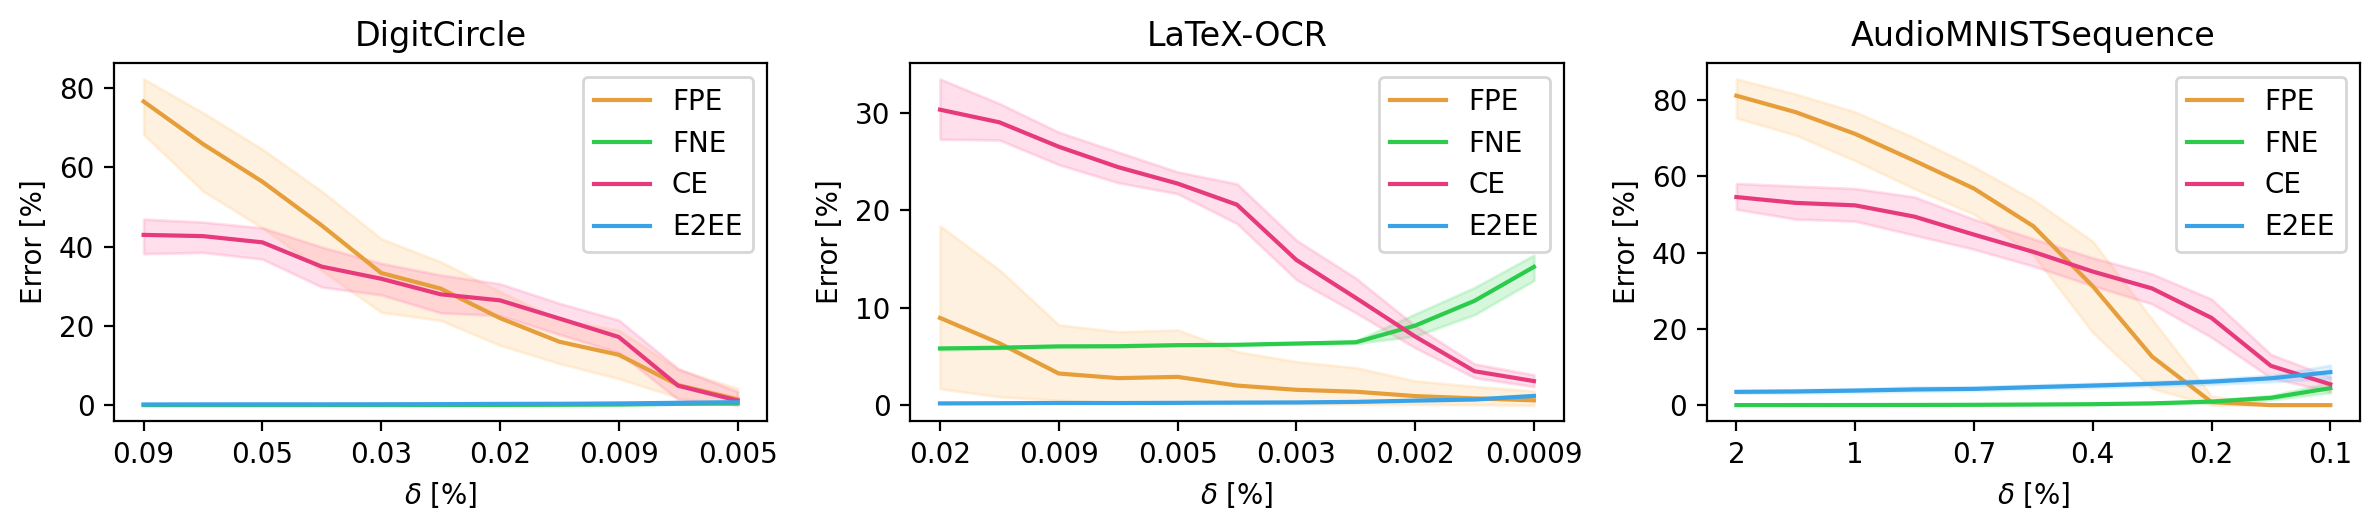

In [11]:
plot_error_vs_sparsity(
    all_results, {"fpe": "FPE", "fne": "FNE", "ce": "CE", "e2e_edit": "E2EE"}
)
plt.savefig("output/error-vs-sparsity.png")

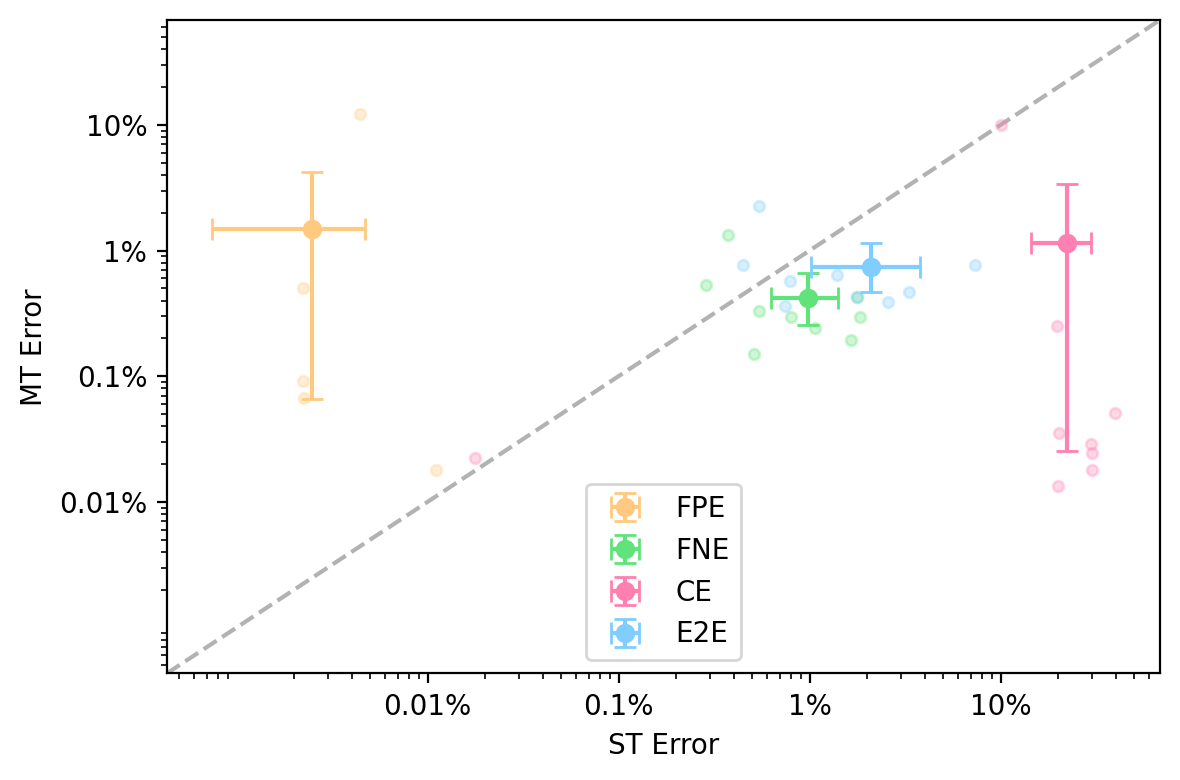

In [12]:
import matplotlib.ticker as mticker
from pixel_art.utils.bootstrap import bootstrap_mean
from pixel_art.theme import color_by_column

label_map = {"fpe": "FPE", "fne": "FNE", "ce": "CE", "e2e_edit": "E2E"}
columns = ["fpe", "fne", "ce", "e2e_edit"]

st_data = all_results["DigitCircle"][0]["ST"]
mt_data = all_results["DigitCircle"][0]["MT"]

_, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200, tight_layout=True)

for col in columns:
    st_vals, mt_vals = st_data[col], mt_data[col]
    st_mean, mt_mean = st_vals.mean(), mt_vals.mean()
    st_lo, st_hi = bootstrap_mean(st_vals)
    mt_lo, mt_hi = bootstrap_mean(mt_vals)
    ax.scatter(
        st_vals, mt_vals,
        color=color_by_column[col], alpha=0.3, s=15, zorder=1,
    )
    ax.errorbar(
        st_mean, mt_mean,
        xerr=[[st_mean - st_lo], [st_hi - st_mean]],
        yerr=[[mt_mean - mt_lo], [mt_hi - mt_mean]],
        fmt="o", color=color_by_column[col], label=label_map[col],
        capsize=4, markersize=6, zorder=2,
    )

ax.set_xscale("log")
ax.set_yscale("log")
lo = min(ax.get_xlim()[0], ax.get_ylim()[0])
hi = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([lo, hi], [lo, hi], "k--", alpha=0.3, zorder=0)
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)

ticks = [0.01, 0.1, 1, 10]
tick_labels = ["0.01%", "0.1%", "1%", "10%"]
for a in [ax.xaxis, ax.yaxis]:
    a.set_ticks(ticks)
    a.set_ticklabels(tick_labels)
    a.set_minor_formatter(mticker.NullFormatter())

ax.set_xlabel("ST Error")
ax.set_ylabel("MT Error")
ax.legend()
plt.savefig("output/st-vs-mt.png")